<a href="https://colab.research.google.com/github/Teratoma111/amazon_review_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from sklearn.model_selection import KFold
from torchtext.legacy import data as data_leg
from torchtext import data
import numpy as np  
import torch.optim as optim
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data_leg.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data_leg.LabelField()
from google.colab import drive
drive.mount('/content/drive')
import random

fields = {'reviewText': ('text', TEXT), 'overall': ('label', LABEL)}
train_data= data_leg.TabularDataset.splits(
                                        path = '/content/drive/MyDrive',
                                        train = "Musical_Instruments_5.json",
                                        format = 'json',
                                        fields = fields)[0]
for i in range(0, len(train_data)):
  if(len(train_data[i].text) < 1):
    train_data[i].text = train_data[3].text
    train_data[i].label = train_data[3].label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def get_fold_data(train_data, num_folds=5):
        
        TEXT = data_leg.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
        LABEL = data_leg.LabelField()
        fields = [('text', TEXT), ('label', LABEL)]
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state = 42)
        train_data_arr = np.array(train_data.examples)
        for train_index, val_index in kf.split(train_data_arr):
            yield(
                TEXT,
                LABEL,
                data_leg.Dataset(train_data_arr[train_index], fields=fields),
                data_leg.Dataset(train_data_arr[val_index], fields=fields),
            )

In [3]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)

In [4]:
def get_weights(iterator):
  weights = torch.zeros(len(LABEL.vocab))
  for batch in iterator:
    for i in batch.label:
      weights[i.cpu().numpy()] +=1
  for i in range(0, len(LABEL.vocab)):
    weights[i] = (1 / weights[i]) * 100
  return weights

In [5]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    y_score = top_pred.detach().cpu().numpy()
    y_true = y.view_as(top_pred).cpu().numpy()
    f1 = f1_score(y_true, y_score, average = 'weighted')
    rec = recall_score(y_true, y_score, average = 'weighted')
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return (rec, f1, acc)

In [6]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        metrics = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        acc = metrics[2]
        f1 = metrics[1]
        rec = metrics[0]
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1
        epoch_rec += rec
    epoch_acc /= len(iterator)
    epoch_f1 /= len(iterator)
    epoch_rec /= len(iterator)
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [7]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)
            
            metrics = categorical_accuracy(predictions, batch.label)

            acc = metrics[2]
            f1 = metrics[1]
            rec = metrics[0]
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_rec += rec
        epoch_acc /= len(iterator)
        epoch_f1 /= len(iterator)
        epoch_rec /= len(iterator)
        
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [8]:
import time
from torchtext import data, datasets
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
fold_id = 0
for TEXT, LABEL, train_data, val_data in get_fold_data(train_data):
  print(f'Fold index: {fold_id}.')
  fold_id +=1
  TEXT.build_vocab(train_data, 
            vectors = "fasttext.simple.300d", 
            unk_init = torch.Tensor.normal_)
  print(f'Embedding size: {TEXT.vocab.vectors.size()}.')
  LABEL.build_vocab(train_data) 
  BATCH_SIZE = 64

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  train_iterator, valid_iterator = data_leg.BucketIterator.splits(
      (train_data, val_data), 
      batch_size = BATCH_SIZE,
      sort_key = lambda x: len(x.text),
      #sort_within_batch = False,
      sort_within_batch = True, 
      device = device)
  
  pretrained_embeddings = TEXT.vocab.vectors
  INPUT_DIM = len(TEXT.vocab)
  EMBEDDING_DIM = 300
  HIDDEN_DIM = 512
  OUTPUT_DIM = len(LABEL.vocab)
  N_LAYERS = 4
  BIDIRECTIONAL = True
  DROPOUT = 0.5
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  model = RNN(INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX)
  model.embedding.weight.data.copy_(pretrained_embeddings)
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

  optimizer = optim.Adam(model.parameters())

  criterion = nn.CrossEntropyLoss(weight =  get_weights(train_iterator))

  model = model.to(device)
  criterion = criterion.to(device)
  N_EPOCHS = 10

  best_valid_score = float('0')

  for epoch in range(N_EPOCHS):

      start_time = time.time()
      train_res = train(model, train_iterator, optimizer, criterion)
      train_loss = train_res[0]
      train_score = train_res[1]
      valid_res = evaluate(model, valid_iterator, criterion)
      valid_score = valid_res[1]
      valid_loss = valid_res[0]
      end_time = time.time()
      valid_acc = (valid_score[1])
      acc = valid_acc
      #print(float(valid_acc))
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      if acc > best_valid_score:
          best_valid_score= acc
          torch.save(model.state_dict(), '/content/drive/MyDrive/mo1.pt')
          print(f'\tValid Loss: {valid_loss:.3f} | Valid F1: {valid_score[1]*100:.2f}% | Valid rec: {valid_score[0]*100:.2f}% | Valid acc: {valid_score[2]*100:.2f}%')
      print(f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_score[1]*100:.2f}% | Train rec: {train_score[0]*100:.2f}% | Train acc: {train_score[2]*100:.2f}%')

Fold index: 0.
Embedding size: torch.Size([25827, 300]).


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 1m 42s
	Valid Loss: 1.604 | Valid F1: 50.50% | Valid rec: 49.59% | Valid acc: 49.59%
	Train Loss: 1.618 | Train F1: 27.99% | Train rec: 28.92% | Train acc: 28.92%
Epoch: 02 | Epoch Time: 1m 44s
	Valid Loss: 1.602 | Valid F1: 57.32% | Valid rec: 62.94% | Valid acc: 62.94%
	Train Loss: 1.590 | Train F1: 40.53% | Train rec: 37.86% | Train acc: 37.86%
Epoch: 03 | Epoch Time: 1m 44s
	Train Loss: 1.513 | Train F1: 42.05% | Train rec: 37.60% | Train acc: 37.60%
Epoch: 04 | Epoch Time: 1m 45s
	Train Loss: 1.390 | Train F1: 45.94% | Train rec: 41.72% | Train acc: 41.72%
Epoch: 05 | Epoch Time: 1m 45s
	Train Loss: 1.268 | Train F1: 46.30% | Train rec: 41.91% | Train acc: 41.91%
Epoch: 06 | Epoch Time: 1m 45s
	Valid Loss: 1.903 | Valid F1: 58.83% | Valid rec: 60.10% | Valid acc: 60.10%
	Train Loss: 1.185 | Train F1: 48.31% | Train rec: 45.13% | Train acc: 45.13%
Epoch: 07 | Epoch Time: 1m 44s
	Train Loss: 0.987 | Train F1: 54.44% | Train rec: 50.98% | Train acc: 50.98%
Epo

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


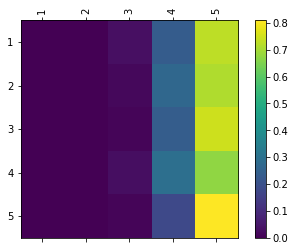

In [13]:

n_categories = len(LABEL.vocab)
confusion = np.zeros((n_categories, n_categories))

model.eval()
sum = 0
with torch.no_grad():
    for batch in train_iterator:
      text, text_lengths = batch.text
      predictions = model(text, text_lengths).squeeze(1)
      y = batch.label
      top_pred = predictions.argmax(1, keepdim = True)
      y_score = top_pred.detach().cpu().numpy()
      y_true = y.view_as(top_pred).cpu().numpy()
      for i in range(0, y_true.shape[0]):
        confusion[[y_true[i] , y_score[i]]] +=1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)
all_categories = [1, 2, 3 ,4 ,5]
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

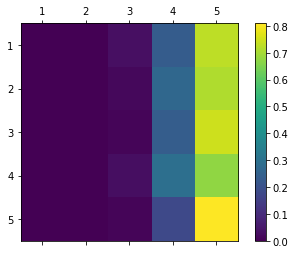

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)
all_categories = [1, 2, 3 ,4 ,5]
ax.set_xticklabels([''] + all_categories)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()